# AO Simulation PSD

Developing the proper transfer function for an AO system, beyond just a high pass filter. This is developing off of previous HCIPy simulations. Simply putting a percentage on AO efficiency isn't cutting it.

In [3]:
from hcipy import *
from hcipy import atmosphere
from hcipy import fourier
import numpy as np
from matplotlib import pyplot as plt
import turb_sims as ts
from functools import partial
from importlib import reload
from photutils.profiles import RadialProfile

In [4]:
# lmao
import warnings
warnings.filterwarnings("ignore")

### Setup 

This setup was copied from unmo_pfs_LCO on a personal file

In [5]:
wavelength = 800.0e-9
Dtel = 6.5
pad = 2
Dgrid = 60/56 * Dtel
n_bin = 4 #this allows us to oversample our pupil
grid = make_pupil_grid(60*n_bin, Dgrid) # could suepersample this to stop aliasing errors
grid_pad = make_pupil_grid(60*n_bin*pad, Dgrid*pad)
wfs_grid = make_pupil_grid(120*n_bin, 2 * Dgrid)

In [6]:
# Padding math
h_pad = 60*n_bin*pad
h_reg = 60*n_bin

def window_field(field, new_grid, h, x0=0, y0=0):
    cropped_field = field.shaped[(y0-h//2):(y0+h//2), (x0 - h//2):(x0+h//2)]
    return Field(cropped_field.ravel(), new_grid)

crop_pad = partial(window_field, new_grid=grid, h=h_reg, x0=h_pad//2, y0=h_pad//2)

In [7]:
# setting up the pyramid pwfs
pwfs = PyramidWavefrontSensorOptics(grid, wfs_grid, separation=Dgrid, pupil_diameter=Dtel, wavelength_0=wavelength, q=4) # q gives pixels per lambda over D
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, 3 * wavelength/Dtel, num_steps=20) #, fast_modulation_method=True) # had to exlude bc not on sebastiaans version

In [8]:
aperture = evaluate_supersampled(make_magellan_aperture(), grid, 8) # anti aliasing filter => softens filter
wf = Wavefront(aperture, wavelength)
wf.total_power = 1.0

In [9]:
# shoing we can window down from 
aperture_pad = evaluate_supersampled(make_magellan_aperture(), grid_pad, 8) 
h_pad = 60*n_bin*pad
h_reg = 60*n_bin
crop_aperture = crop_pad(aperture_pad)

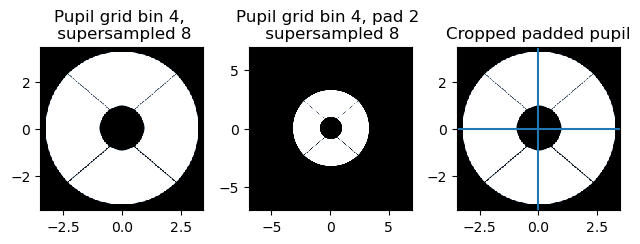

In [10]:
plt.subplot(1,3,1)
plt.title(f"Pupil grid bin {n_bin}, \n supersampled 8")
imshow_field(aperture, cmap='bone')

plt.subplot(1,3,2)
plt.title(f"Pupil grid bin {n_bin}, pad {pad} \n supersampled 8")
imshow_field(aperture_pad, cmap='bone')

plt.subplot(1,3,3)
plt.title(f"Cropped padded pupil")
imshow_field(crop_aperture, cmap='bone')
plt.axhline(0)
plt.axvline(0)

plt.tight_layout()
plt.show()

In [11]:
# number of illuminated actuators: 48
# q is our zero padding. we're at 4 now probably need to increase
ff = FourierFilter(grid, make_rectangular_aperture(2 * np.pi * 48 / Dtel), q=4)
ff_pad = FourierFilter(grid_pad, make_rectangular_aperture(2 * np.pi * 48 / Dtel), q=4)

In [12]:
# simplified aperture for minimizing funky ff residuals
circ_ap = evaluate_supersampled(make_circular_aperture(6.5), grid, 4)
circ_ap_pad = evaluate_supersampled(make_circular_aperture(6.5), grid_pad, 4)

## Testing: Propagation and ringing

In [13]:
def filter(phase, ff, ao_eff=1.0):
    phase_ms = phase - np.mean(phase)
    phase_filt = np.real(ff.forward(phase_ms +0j))
    phase_res = phase_ms - ao_eff * phase_filt
    return phase_res

def filter_crop(phase_pad, ff_pad, window_fn, ao_eff=1.0):
    phase_res_pad = filter(phase_pad, ff_pad, ao_eff=ao_eff)
    phase_res_crop = window_fn(phase_res_pad)
    return phase_res_crop

def PA_PL_phase(grid_p, diam, ff_p, window_fn, aperture, WFE_nm, wavelength, ao_eff=1.0, pl_exp=-11/3):
    ptv = 1 # TODO: check if this seems right
    phase_pl = make_power_law_error(grid_p, ptv, diam, exponent=pl_exp)
    phase_res_pl = filter_crop(phase_pl, ff_p, window_fn, ao_eff=ao_eff)
    # scaling 
    WFE_rad = WFE_nm * 2 * np.pi / wavelength # taking desired WFE to radians
    phase_res_pl *= WFE_rad / np.std(phase_res_pl[aperture>0])
    # create the PA optic - e^{i*phi} => expect phase 
    return phase_res_pl

def PA_LCO_phase(grid_p, ff_p, window_fn, r0, wavelength, L0=25, ao_eff=1.0):
    # generate the atmospheric layers 
    cn2 = atmosphere.Cn_squared_from_fried_parameter(r0)
    layer = atmosphere.InfiniteAtmosphericLayer(grid_p, cn2, L0=L0)
    phase_LCO = layer.phase_for(wavelength) # Field, units of radians
    # filter out modes AO can control.
    phase_res_LCO = filter_crop(phase_LCO, ff_p, window_fn, ao_eff=ao_eff)
    return phase_res_LCO

### Residuals look reasonable

In [14]:
# powerlaw phase residuals
WFE_nm = 90e-9
pl_phase_res = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, WFE_nm, wavelength, ao_eff=1.0)
# LCO phase residual.s
r0 = 0.05
lco_phase_res = PA_LCO_phase(grid_pad, ff_pad, crop_pad, r0, wavelength, L0=25, ao_eff=1.0)

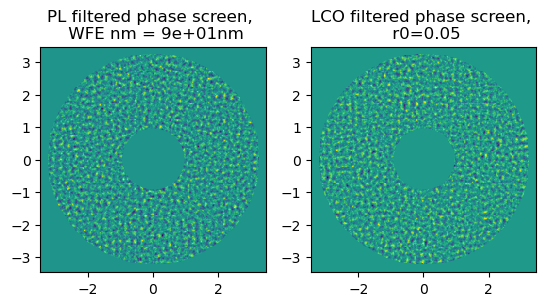

In [15]:
plt.subplot(1,2,1)
plt.title(f"PL filtered phase screen, \n WFE nm = {WFE_nm*1e9:0.2}nm")
imshow_field(pl_phase_res*aperture)

plt.subplot(1,2,2)
plt.title(f"LCO filtered phase screen, \n r0={r0}")
imshow_field(lco_phase_res*aperture)

plt.show()


### Propagaing to focal plane looks right:

In [16]:
# setting up focal place propagation
spatial_resolution = wavelength / Dtel
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=spatial_resolution)
prop = FraunhoferPropagator(grid, focal_grid)
psf_ref = prop(wf).power
norm = prop(wf).power.max()

In [17]:
# prop the power law residuals
abr_pl = PhaseApodizer(pl_phase_res*aperture)
psf_pl = prop(abr_pl(wf)).power

# prop the LCO residuals
abr_lco = PhaseApodizer(lco_phase_res*aperture)
psf_lco = prop(abr_lco(wf)).power

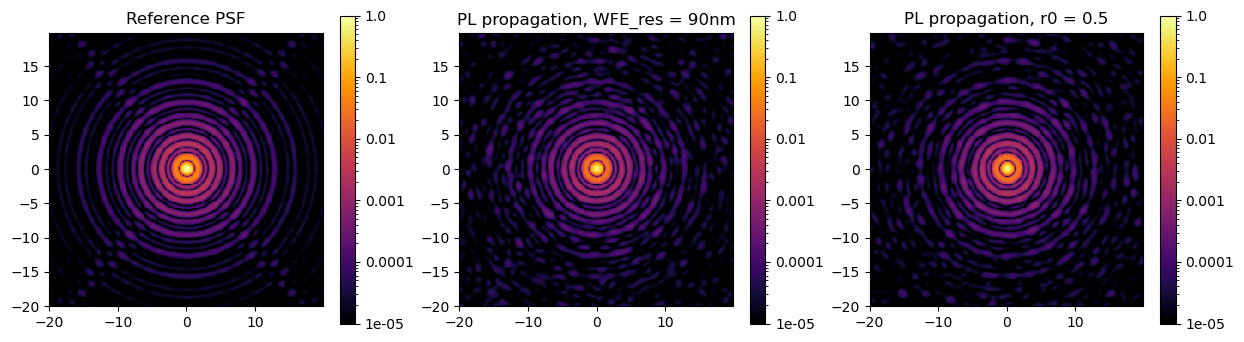

In [18]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.title("Reference PSF")
imshow_psf(psf_ref / norm, vmax=1, vmin=1e-5, spatial_resolution=spatial_resolution)

plt.subplot(1,3,2)
plt.title("PL propagation, WFE_res = 90nm")
imshow_psf(psf_pl / norm, vmax=1, vmin=1e-5, spatial_resolution=spatial_resolution)

plt.subplot(1,3,3)
plt.title("PL propagation, r0 = 0.5")
imshow_psf(psf_lco / norm, vmax=1, vmin=1e-5, spatial_resolution=spatial_resolution)

plt.show()

In [19]:
# calculating the SR
SR_pl = get_strehl_from_focal(psf_pl, psf_ref).to_dict()['values']
SR_LCO = get_strehl_from_focal(psf_lco, psf_ref).to_dict()['values']
print("power law: ",SR_pl)
print("LCO turb: ",SR_LCO)

power law:  0.6094077699258491
LCO turb:  0.6393361873499722


## Testing AO efficiency

In [64]:
fft = FastFourierTransform(grid, q=8, fov=0.5)

spatial_resolution = wavelength / Dtel
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=spatial_resolution)
prop = FraunhoferPropagator(grid, focal_grid)

def my_psd(PSD):
    n = int(np.sqrt(PSD.shape))
    mid = n//2
    PSD_reshape = PSD.reshape((n,n))
    # create array of radii
    x,y = np.meshgrid(np.arange(n),np.arange(n))
    R = np.sqrt((x-mid)**2+(y-mid)**2)
    r  = np.linspace(1,mid,num=mid)
    # doing the radial means:
    f_psd = lambda r : PSD_reshape[(R >= r-.5) & (R < r+.5)].mean()
    mean_r = np.vectorize(f_psd)(r)
    return mean_r

def my_psd_2d(phi, ap):
    PSD_2D = abs(fft.forward(ap*phi))**2
    return PSD_2D

def my_psf_2d(phi, ap):
    # need to eiphi this one
    psf_2d = abs(fft.forward(ap*np.exp(1.j*phi)))**2
    return psf_pl

def psd_from_phi(phi, ap):
    PSD_2D = my_psd_2d(phi, ap)
    return my_psd(PSD_2D)

In [21]:
# Generating phases for differnt percentage of AO filtering
pl_phase_res_100 = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, WFE_nm, wavelength, ao_eff=1.0)
pl_phase_res_999 = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, WFE_nm, wavelength, ao_eff=0.999)
pl_phase_res_997 = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, WFE_nm, wavelength, ao_eff=0.997)
pl_phase_res_995 = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, WFE_nm, wavelength, ao_eff=0.995)
pl_phase_res_99 = PA_PL_phase(grid_pad, Dgrid*pad, ff_pad, crop_pad, aperture, WFE_nm, wavelength, ao_eff=0.99)

In [22]:
# creating PSFs or 2D PSDs 
PSD_res_100 = my_psd_2d(pl_phase_res_100, aperture)
PSD_res_999 = my_psd_2d(pl_phase_res_999, aperture)
PSD_res_997 = my_psd_2d(pl_phase_res_997, aperture)
PSD_res_995 = my_psd_2d(pl_phase_res_995, aperture)
PSD_res_99 = my_psd_2d(pl_phase_res_99, aperture)

In [23]:
# Actual PSDs 
PSD_100_r = my_psd(PSD_res_100)
PSD_999_r = my_psd(PSD_res_999)
PSD_997_r = my_psd(PSD_res_997)
PSD_995_r = my_psd(PSD_res_995)
PSD_99_r = my_psd(PSD_res_99)

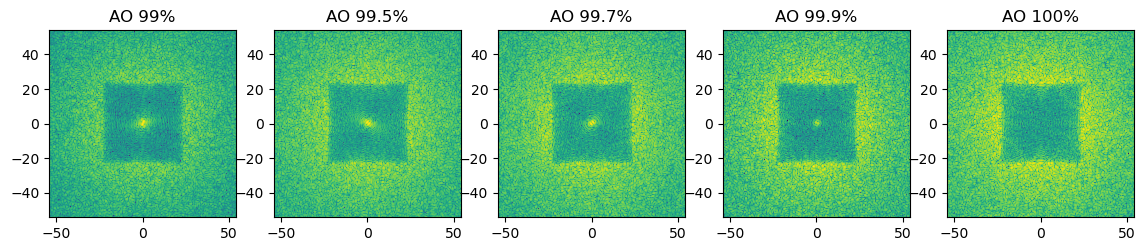

In [24]:
# plotting various amounts of AO filtering on PSF
fig = plt.figure(figsize=(14,5), facecolor='white')
plt.subplot(1,5,1)
plt.title("AO 99%")
imshow_field(np.log(PSD_res_99))
plt.subplot(1,5,2)
plt.title("AO 99.5%")
imshow_field(np.log(PSD_res_995))
plt.subplot(1,5,3)
plt.title("AO 99.7%")
imshow_field(np.log(PSD_res_997))
plt.subplot(1,5,4)
plt.title("AO 99.9%")
imshow_field(np.log(PSD_res_999))
plt.subplot(1,5,5)
plt.title("AO 100%")
imshow_field(np.log(PSD_res_100))
plt.show()

In [45]:
# getting x coords correct
r_x = np.linspace(0,48,num=PSD_100_r.shape[0])

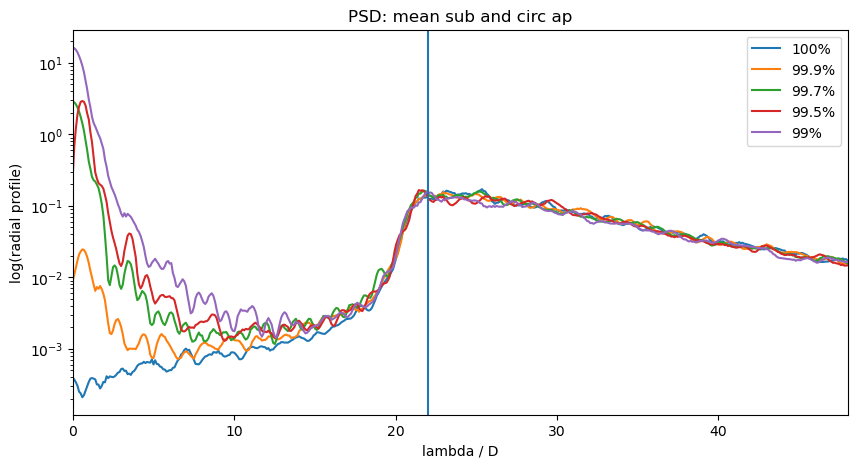

In [49]:
# Plotting PSDs
fig,ax=plt.subplots(figsize=(10,5))
plt.title("PSD: mean sub and circ ap")
ax.plot(r_x, PSD_100_r, label="100%")
ax.plot(r_x, PSD_999_r, label="99.9%")
ax.plot(r_x, PSD_997_r, label="99.7%")
ax.plot(r_x, PSD_995_r, label="99.5%")
ax.plot(r_x, PSD_99_r, label="99%")
plt.axvline(22)
plt.yscale('log')
plt.xlabel('lambda / D')
plt.ylabel('log(radial profile)')
plt.xlim(0, 48)
plt.legend()
plt.show()

## Comparing filtered components

In [26]:
# fourier filter is explicitly a rectangle
ff = FourierFilter(grid, make_rectangular_aperture(2 * np.pi * 48 / Dtel), q=4)
# distinctly, fourier transform is described seperately as:
fft = FastFourierTransform(grid, q=8, fov=0.5)

In [65]:
def filter_v(phase, ff, ao_eff=1.0):
    phase_ms = phase - np.mean(phase)
    phase_filt = np.real(ff.forward(phase_ms +0j))
    phase_res = phase_ms - ao_eff * phase_filt
    return phase_res, phase_filt, phase_ms

def PA_PL_phase_v(grid_p, diam, window, ff_p, aperture, WFE_nm, wavelength, ao_eff=1.0, pl_exp=-11/3):
    ptv = 1 # TODO: check if this seems right
    phase_pl = make_power_law_error(grid_p, ptv, diam, exponent=pl_exp)
    phase_res_pl, phase_filt_pl, phase_ms_pl = filter_v(phase_pl, ff_p, ao_eff=ao_eff)
    # scaling 
    WFE_rad = WFE_nm * 2 * np.pi / wavelength # taking desired WFE to radians
    phase_res_pl *= WFE_rad / np.std(phase_res_pl[aperture>0])
    phase_filt_pl *= WFE_rad / np.std(phase_res_pl[aperture>0])
    phase_pl *= WFE_rad / np.std(phase_res_pl[aperture>0])
    # create the PA optic - e^{i*phi} => expect phase 
    return window(phase_res_pl), window(phase_filt_pl), window(phase_pl)

def PA_LCO_phase_v(grid_p, ff_p, window, r0, wavelength, L0=25, ao_eff=1.0):
    # generate the atmospheric layers 
    cn2 = atmosphere.Cn_squared_from_fried_parameter(r0)
    layer = atmosphere.InfiniteAtmosphericLayer(grid_p, cn2, L0=L0)
    phase_LCO = layer.phase_for(wavelength) # Field, units of radians
    # filter out modes AO can control.
    phase_res, phase_filt, phase_ms = filter_v(phase_LCO, ff_p, ao_eff=ao_eff)
    return window(phase_res), window(phase_filt), window(phase_LCO)

In [66]:
WFE_nm = 90e-9
r0 = 0.05
AO = 1.0
# power law vs. full LCO turbulence generation
phase_res_pl, phase_filt_pl, phase_ms_pl = PA_PL_phase_v(grid_pad, Dgrid*pad, crop_pad, ff_pad, aperture_pad, WFE_nm, wavelength, ao_eff=AO)
phase_res_lco, phase_filt_lco, phase_ms_lco = PA_LCO_phase_v(grid_pad, ff_pad, crop_pad, r0, wavelength, L0=25, ao_eff=AO)

In [67]:
# generating FT of each components:
PSD = abs(fft.forward(phase_ms_lco * aperture))**2
PSD_filt = abs(fft.forward(phase_filt_lco * aperture))**2
PSD_res = abs(fft.forward(phase_res_lco * aperture))**2
# generating FT of each components:
PFD = abs(fft.forward(np.exp(1.j*phase_ms_lco * aperture)))**2
PFD_filt = abs(fft.forward(np.exp(1.j*phase_filt_lco * aperture)))**2
PFD_res = abs(fft.forward(np.exp(1.j*phase_res_lco * aperture)))**2

In [68]:
# actual way to do this:
PSF = my_psd_2d(phase_ms_lco, aperture)
PSF_filt = my_psd_2d(phase_filt_lco, aperture)
PSF_res = my_psd_2d(phase_res_lco, aperture)

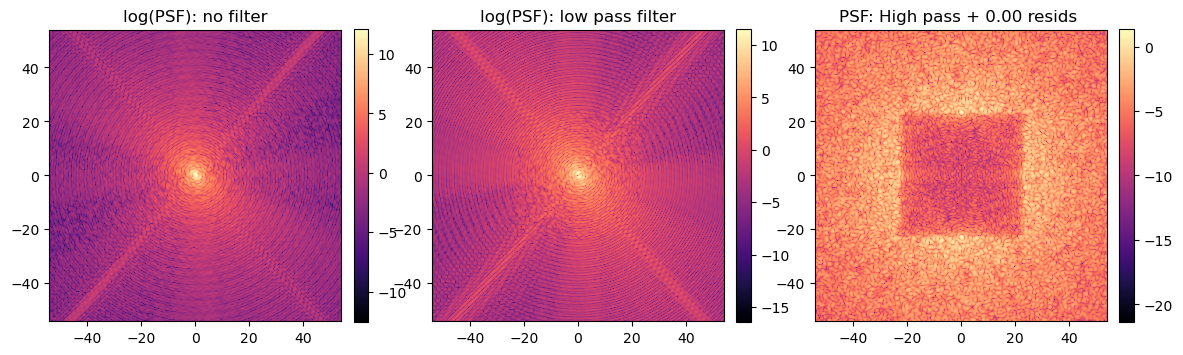

In [69]:
fig = plt.figure(figsize=(14,5), facecolor='white')
# expected control region

plt.subplot(1,3,1)
plt.title("log(PSF): no filter")
imshow_field(np.log(PSF), cmap='magma')
plt.colorbar(fraction=0.046, pad=0.04)

#########################
plt.subplot(1,3,2)
plt.title("log(PSF): low pass filter")
imshow_field(np.log(PSF_filt), cmap='magma')
circle1 = plt.Circle((0, 0), 24, color='r', fill=False)
plt.colorbar(fraction=0.046, pad=0.04)

#############################
plt.subplot(1,3, 3)
plt.title("PSF: High pass + 0.00 resids ")
imshow_field(np.log(PSF_res), cmap='magma')
circle2 = plt.Circle((0, 0), 24, color='r', fill=False)
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

In [70]:
# add in a coronagraph (?)

In [71]:
psd = my_psd(PSF)
psd_filt = my_psd(PSF_filt)
psd_res = my_psd(PSF_res)

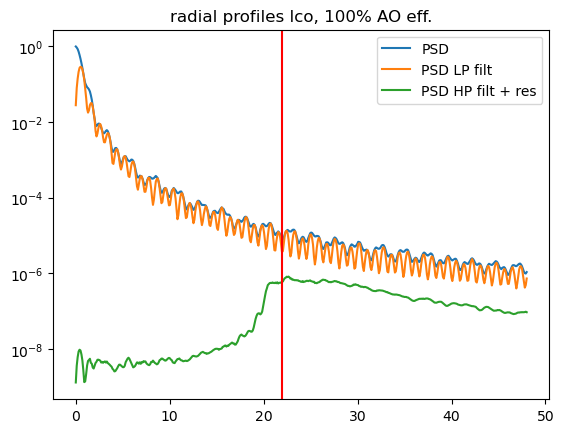

In [76]:
r_x = np.linspace(0,48,num=psd.shape[0])

plt.title("radial profiles lco, 100% AO eff.")
plt.plot(r_x, psd / np.max(psd), label = 'PSD')
plt.plot(r_x, psd_filt / np.max(psd), label = 'PSD LP filt')
plt.plot(r_x, psd_res / np.max(psd), label = 'PSD HP filt + res')
plt.axvline(22, c='r')
plt.yscale('log')
plt.legend()
plt.show()

In [74]:
psd.shape

(480,)

## Adding other sources of noise

This is not a complete simulation of WFS performance. We also need to add WFS noise (which is source dependent) and servo lag error. 

"You can calculate what the noise+servo-lag residual PSD ratio is from contrast C2 in G2005, but see Appendix B of M&G 2018, especially equation 102." This is just a control region thing, and "you have to do a little book keeping to turn that into a PSD ratio instead of a variance"

Equation 102: the wavefront variance from measurement noise given by Eq 52 total residual variance at the science wavelength:
$$
\sigma^{\dagger 2}_{mn} = \left( \frac{\lambda_0}{\lambda}  \right)^2 \frac{P(\vec{k})}{D^2} ( 2 \pi \vec{k}_{mn} \cdot \vec{\nu})^2 \tau_{tl}^2
+ \frac{\Beta^2_{p} ( \vec{k}_{mn})}{ (S / N)^2 }\left( \frac{\lambda_{wfs}}{\lambda}  \right)^2 (rad^2 rms)
$$

open loop framework, time lag is:
$$
\tau_{tl} = \tau_{wfs} + \tau
$$

Equation 52 for reference:
$$
\sigma^2_{ph, mn} = \frac{\beta^2_p (\vec{k}_{mn})}{(S / N)^2} (rad^2 rms)
$$

Where $ \beta_p(\vec{k}_{mn}) $ is the "sensitivity of the WFS to photon noise"

$$
S / N  = \frac{F_{\gamma} \tau_{wfs}}{\sqrt{F_{\gamma} \tau_{wfs} + n_{px}F_{bg} \tau_{wfs} + n_{px} \sigma^2_{ron}}}
$$

In [155]:
# variables needed
D = 6.5
k_mn = np.linspace(0,48,num=psd.shape[0]) #TODO # spatial frequency vector, linspace on dimension

# for time delay:
lam_0 = 800e-9 # reference wavelenghth for turbulence parameters
lam = 800e-9 # wavelenght of onservation, wfs
Pk_D2 = psd # ?? I think this is my 2d psd... not filtered?
V = 18.7 # m/s wind speed, weighted, with direction?

# time delays
t_wfs = 0.0005 #s WFS exposure time 
t = 0.00008 # closed loop delay, 6.1 (?)
t_tl = t_wfs + t # time lag
t_tl = 0.5e-4 # eden is optimizing 

# photon noise error:
beta_p = 2*np.sqrt(2)  # WFS sensitivity  
n_px = 7280 # pixel count 
F_0flux = 5.9e10 #Photos/s zero mag photon flux
F_bg = 0.22 # Photons/pix/s background flux
sigma_ron_1 = 0.1 # electrons => readoutnoise
sigma_ron_2 = 5.0e7 # photons/sec/m^2/nm => 0 mag flux density
sigma_ron_3 = 20 # mags/arcsec^2 => sky background
sigma_ron = sigma_ron_1

53.64877256940046

Solvng for an optimal $t_{tl}$, assumng $t_{tl} = t_{wfs}$. 

$$
\frac{d}{d \tau} \sigma_{ph} = \frac{- \beta_c (a\tau + 2b)}{c \tau^3}
$$
$$
\frac{d}{d \tau} \sigma_{sl} = <h> (2 \pi k_{mn} \nu)^2  *2\tau
$$

which means when we minimize we get:
$$
0 = \frac{- \beta_c (a\tau + 2b)}{c \tau^3} + f*\tau
$$
$$
f*\tau = \frac{\beta_c (a\tau + 2b)}{c \tau^3}
$$
$$
f*c*\tau^4 = \beta_c (a\tau + 2b)
$$
$$
\tau^4 = \frac{\beta_c}{f*c} (a\tau + 2b)
$$

so in sum, I'm trying o optimize:
$$
\tau^4 - \frac{a*\beta_c}{f*c}\tau - \frac{2*b*\beta_c}{f*c} = 0
$$

In [127]:
# solving for an optimal t_tl
a = F_flux + n_px*F_bg  # photons / sec
b = n_px * sigma_ron**2 
c = F_flux**2
f_mn = (2*np.pi*k_mn*V/D)**2# ugh is this radially dependent

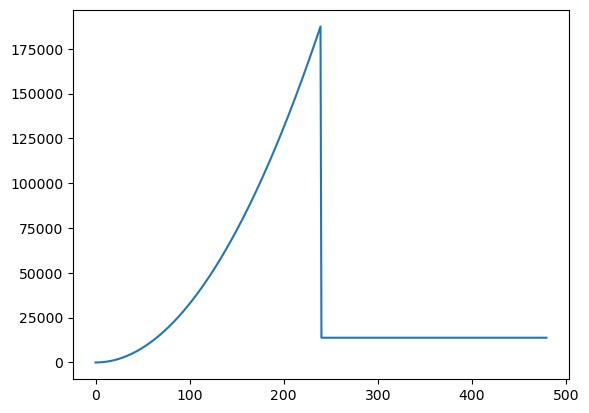

In [128]:
plt.plot(f_mn)

In [130]:
# 
beta_p / (1e6*c)

1.2877779073204828e-24

In [131]:
a

1482014596.1906517

In [115]:
# constant
2*b

145.60000000000002

In [ ]:
# TODO: this is not working, mathmatically or spiritually

**Time lag**

For time lag component, I think it can just be a division:
$$
\sigma^2_{tl, mn} = \left( \frac{\lambda_0}{\lambda}  \right)^2 \frac{P(\vec{k})}{D^2} (2 \pi \vec{k}_{mn} \cdot \vec{\nu})^2 \tau_{tl}^2
$$

So using the spatial PSD defined as, dropping lambda, since everything is the same wavelength:
$$
h^2_{mn} = \frac{P( \vec{k})}{D^2} \left( \frac{\lambda_0}{2 \pi}  \right)^2
$$

We're left with:
$$
\frac{ \sigma^2_{tl, mn}}{h^2_{mn}} = \left( 2 \pi \right)^2 (\vec{k}_{mn} \cdot \vec{\nu})^2 \tau_{tl}^2
$$

Disregarding the direction of wind (???) This looks like a number that increases with distance from center...
$$
\frac{ \sigma^2_{tl, mn}}{h^2_{mn}} = \left( 2 \pi \vec{\nu} \tau_{tl} \right)^2 (\vec{k}_{mn})^2
$$


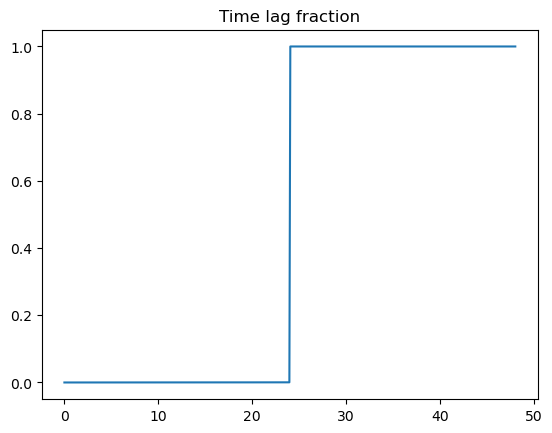

In [152]:
# time lag 
tl_fraction = (2 * np.pi * V * t_tl * k_mn / D) **2
tl_fraction[r_x >24] = 1 # taking the PSD as it is outside of the control region

plt.title("Time lag fraction")
plt.plot(r_x, tl_fraction)
plt.show()


In [157]:
# signal to noise:
s_mag = 6 # source magnitude
F_flux = F_0flux*10**(-s_mag/2.5) # based off zero magnitude flux
SN_2 = (F_flux*t_wfs)**2 / ( (F_flux*t_wfs) + (n_px*F_bg*t_wfs) + (n_px*sigma_ron**2) )
sigma_pn = np.ones_like(r_x)*beta_p**2 / SN_2



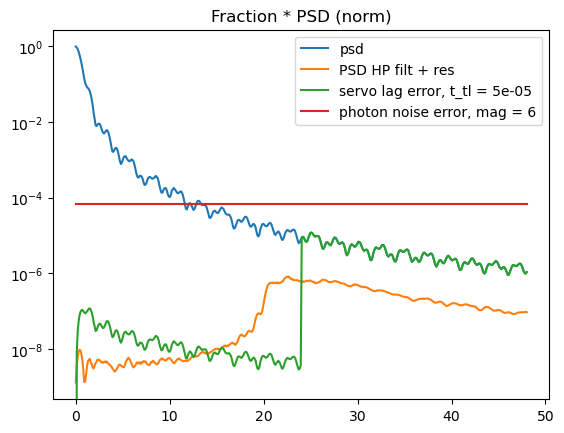

In [160]:
psd_norm = psd / np.max(psd)
sl_err = tl_fraction*psd_norm

plt.title("Fraction * PSD (norm)")
plt.plot(r_x, psd_norm, label='psd') 
plt.plot(r_x, psd_res / np.max(psd), label = 'PSD HP filt + res')
plt.plot(r_x, sl_err, label=f'servo lag error, t_tl = {t_tl}')
plt.plot(r_x, sigma_pn, label=f'photon noise error, mag = {s_mag}')
plt.legend()
plt.yscale('log')
plt.show()

**Photon noise:**

This seems like it can just be added in? Everything is the same wavelength, so simplifying:

$$
\sigma^2_{ph, mn} = \frac{\Beta^2_{p} ( \vec{k}_{mn})}{ (S / N)^2 } 
$$


In [ ]:
SN = 